In [2]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski
%load_ext autoreload
%autoreload 2

Take source embedding and target embedding

Pattern match against source, get target distance to center, produce plots

In [3]:
def make_df(files):
    p = []
    for f in files:
        p.append(f.split('_')[1:-1])

    p = np.array(p)
    p = p.astype(float) 
    df = pd.DataFrame(p, columns=['ntotal', 'hlb_diam','hlb_nmols', 'n_clusters', 'cluster_diam_mean', 'cluster_diam_var','cluster_nmols_mean','cluster_nmols_var','noise_sigma'])
    return df[['hlb_diam','hlb_nmols', 'n_clusters', 'cluster_diam_mean', 'cluster_diam_var','cluster_nmols_mean','cluster_nmols_var','noise_sigma']]

def match_embeddings(source, target, pattern, n=None, d=None, protein='tf'):
    def dist_to_center(ref_arr, arr):
        center = ref_arr.mean(axis=0)
        sqdist = np.sum((arr - center) ** 2, axis=1)
        return np.sqrt(sqdist)
    
    em_source, names_source = source
    em_target, names_target = target
    names_source, names_target = np.array(names_source), np.array(names_target)

    match_rows = pd.Series(names_source).str.contains(pattern).to_numpy()

    match_names = names_source[match_rows]
    dists_target = dist_to_center(em_source[match_rows], em_target)
    dists_source = dist_to_center(em_source[match_rows], em_source[match_rows])
    
    # Get top n indexes
    topn_idxs = np.argsort(dists_target)[:n]
    topn_names = names_target[topn_idxs]
    print(dists_target[topn_idxs[-1]])

    plt.hist(dists_source, bins=50, alpha=0.5, density=True);
    plt.hist(dists_target, bins=50, alpha=0.5, density=True);

    df = make_df(topn_names)
    if protein == 'tf':
        sn.pairplot(df[['n_clusters', 'cluster_diam_var','cluster_nmols_mean','cluster_nmols_var']], diag_kind="kde", height=2)
    elif protein == 'rpb1':
        sn.pairplot(df[['hlb_nmols','hlb_diam','n_clusters', 'cluster_diam_var','cluster_nmols_mean','cluster_nmols_var']], diag_kind="kde", height=2)
    return match_names, topn_names, df


def load_folder(folder):
    l = []
    for f in os.listdir(folder):
        if f[0] == '.':
            continue
        im = fm.load_pickle(os.path.join(folder, f))
        l.append(im)
    return np.array(l)

def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im))

def load_matches(folder, files):
    l = []
    for f in os.listdir(folder):
        if f[0] == '.':
            continue
        if f in files:
            im = fm.load_pickle(os.path.join(folder, f))
            l.append(norm(im))
    return np.array(l)

def view_matches(source_ims, target_ims, zmax=False):
    def equalize(smaller, bigger):
        reps = int(bigger.shape[0] / smaller.shape[0]) + 1
        new = np.tile(smaller, (reps,1,1,1))
        return new[:bigger.shape[0]]
    
    source = source_ims.copy()
    target = target_ims.copy()
    if source.shape[0] < target.shape[0]:
        source = equalize(source, target)
    elif source.shape[0] > target.shape[0]:
        target = equalize(target, source)
    print(source.shape, target.shape)
    fm.viewer([source, target], zmax=zmax)
    
    
    

In [98]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-noisespread_VTBHgoTu__20220619-plussims-20220616-realreal.pkl')

0.2713871294077098


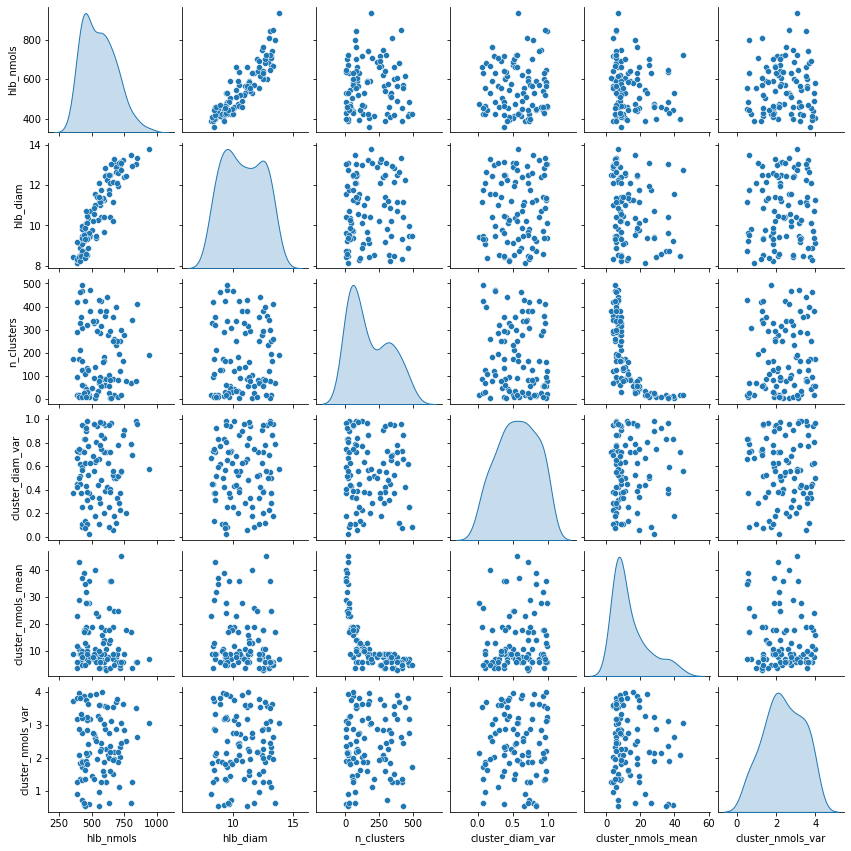

In [141]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-rpb1-nc13-library_sJQraOLX__20220619-plussims-20220616-realreal.pkl')
names_source, names_target, df = match_embeddings(source, target, 'rpb1-nc13-3', 100, protein='rpb1')
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/rpb1-nc13-pairplot.png', dpi=300)

/Users/michaelstadler/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


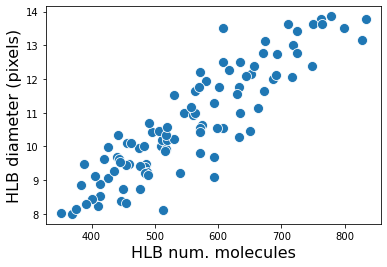

In [69]:
sn.scatterplot(df['hlb_nmols'], df['hlb_diam'], s=100)
plt.xlabel('HLB num. molecules', size=16)
plt.ylabel('HLB diameter (pixels)', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/rpb1-13-2_hlb.png', dpi=300)

/Users/michaelstadler/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


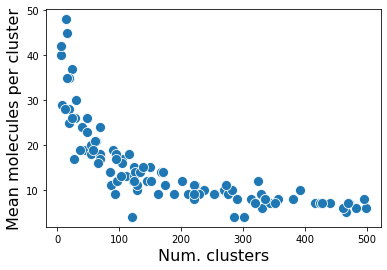

In [70]:
sn.scatterplot(df['n_clusters'], df['cluster_nmols_mean'], s=100)
plt.xlabel('Num. clusters', size=16)
plt.ylabel('Mean molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/rpb1-13-2_clusters.png', dpi=300)

0.3788410454924315


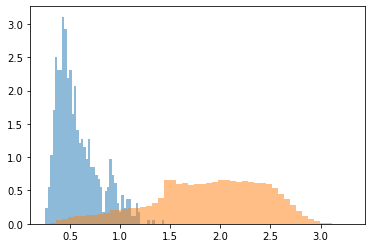

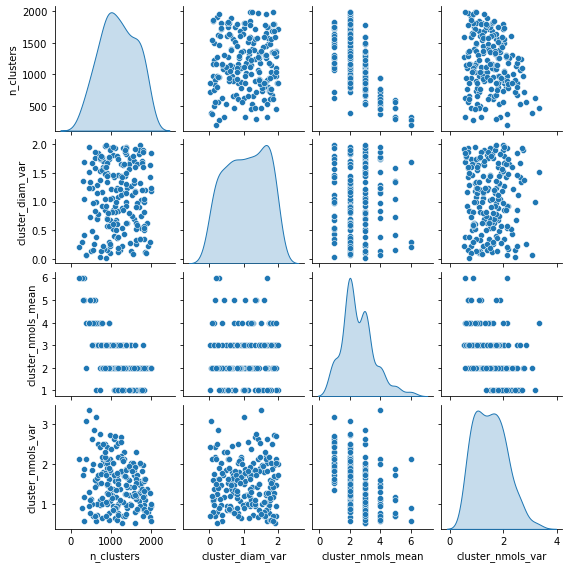

In [4]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl')
names_source, names_target, df1 = match_embeddings(source, target, 'zld-wt_zld-nc13', 200, protein='tf')
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13-pairplot.png', dpi=300)

/Users/michaelstadler/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


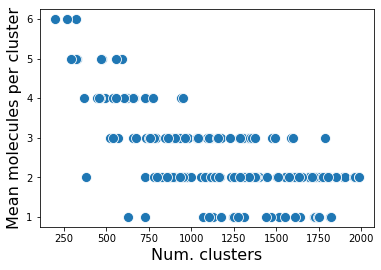

In [156]:
sn.scatterplot(df1['n_clusters'], df1['cluster_nmols_mean'], s=100)
plt.xlabel('Num. clusters', size=16)
plt.ylabel('Mean molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13_clusters.png', dpi=300)

/Users/michaelstadler/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


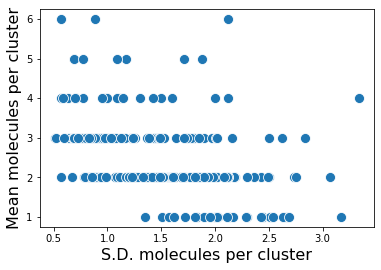

In [157]:
sn.scatterplot(df1['cluster_nmols_var'], df1['cluster_nmols_mean'], s=100)
plt.xlabel('S.D. molecules per cluster', size=16)
plt.ylabel('Mean molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13_clusters_meanvsvar.png', dpi=300)

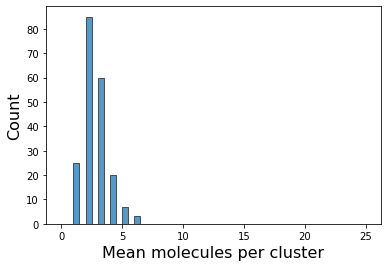

In [212]:
sn.histplot(df1['cluster_nmols_mean'], bins=50, binrange=(0,25))
plt.ylabel('Count', size=16)
plt.xlabel('Mean molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13_molsper_hist.png', dpi=300)

0.9117479825303108


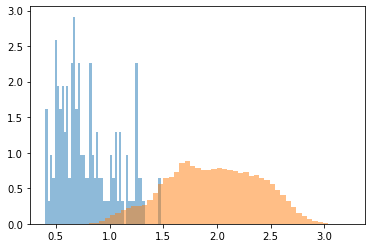

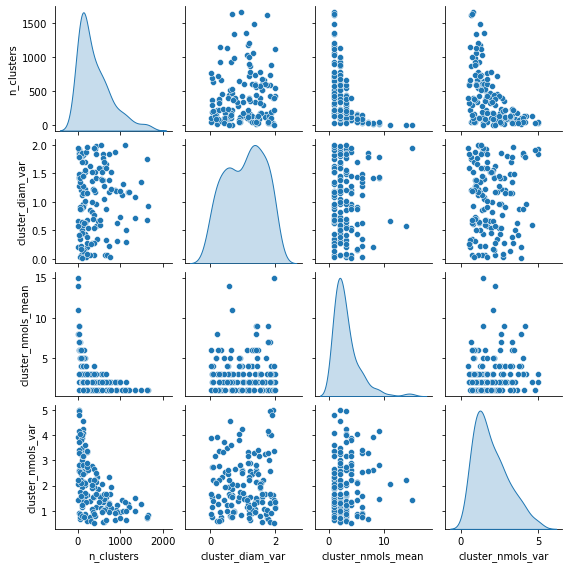

In [5]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl')
names_source, names_target, df2 = match_embeddings(source, target, 'zld-mutzn5-nc13-2', 150, protein='tf')

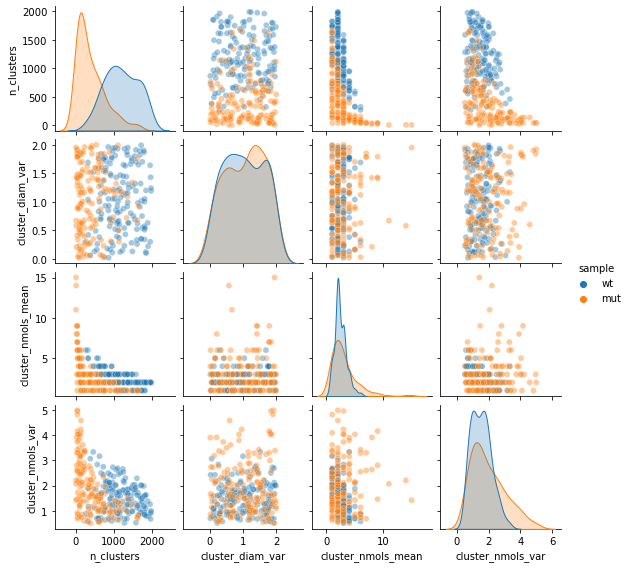

In [170]:
sn.pairplot(data=df3[['n_clusters','cluster_diam_var','cluster_nmols_mean','cluster_nmols_var', 'sample']], diag_kind='kde', kind='scatter', hue='sample', plot_kws=dict(alpha=0.4), height=2)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13-WTvsMut-pairplot.png', dpi=300)

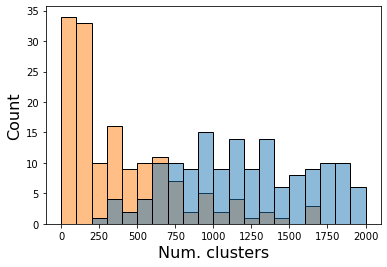

In [211]:
sn.histplot(data=df3, x='n_clusters', hue='sample', bins=20, binrange=(0,2000), legend=False)
plt.ylabel('Count', size=16)
plt.xlabel('Num. clusters', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld_WTvsMut_nclusters_hist.png', dpi=300)

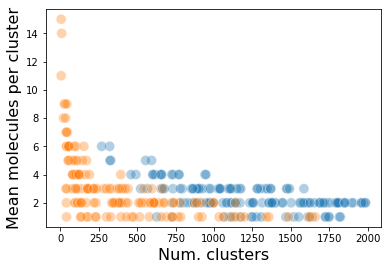

In [195]:
#sn.scatterplot(df1['n_clusters'], df1['cluster_nmols_mean'], s=100)
sn.scatterplot(data=df3, x='n_clusters', y='cluster_nmols_mean', hue='sample', s=100, alpha=0.35, legend=False)
plt.xlabel('Num. clusters', size=16)
plt.ylabel('Mean molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13_WTvsMut_clusters.png', dpi=300)

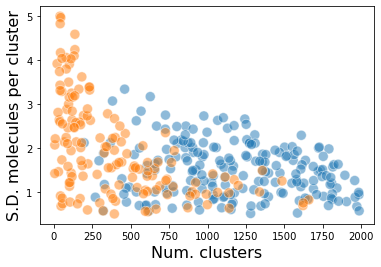

In [7]:
sn.scatterplot(data=df3, x='n_clusters', y='cluster_nmols_var', hue='sample', s=100, alpha=0.5, legend=False)
plt.xlabel('Num. clusters', size=16)
plt.ylabel('S.D. molecules per cluster', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-nc13_WTvsMut_clusters_nclustersvsvar.png', dpi=300)

1.1763693010938006


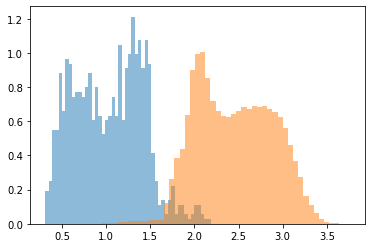

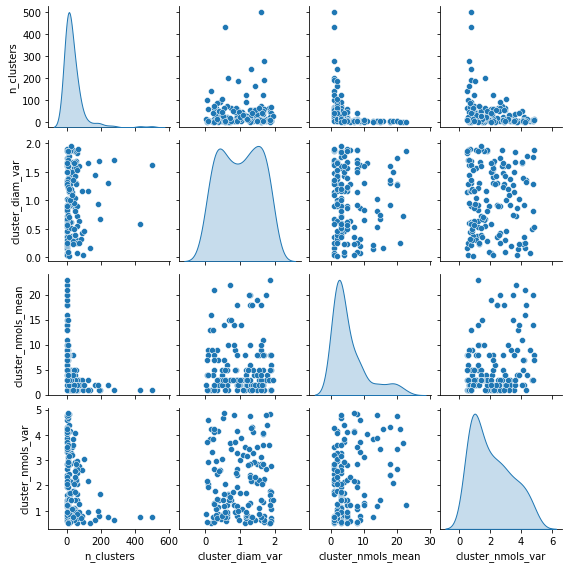

In [220]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl')
names_source, names_target, df_cterm = match_embeddings(source, target, 'zld-cterm', 150, protein='tf')

In [216]:
?sn.histplot

Signature:
sn.histplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='count',
    bins='auto',
    binwidth=None,
    binrange=None,
    discrete=None,
    cumulative=False,
    common_bins=True,
    common_norm=True,
    multiple='layer',
    element='bars',
    fill=True,
    shrink=1,
    kde=False,
    kde_kws=None,
    line_kws=None,
    thresh=0,
    pthresh=None,
    pmax=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
disrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mass,

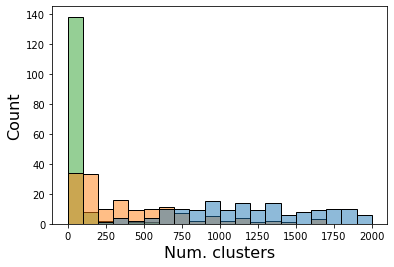

In [218]:
df_cterm['sample'] = 'cterm'
df4  = pd.concat([df3, df_cterm], ignore_index=True)

sn.histplot(data=df4, x='n_clusters', hue='sample', bins=20, binrange=(0,2000), legend=False)
plt.ylabel('Count', size=16)
plt.xlabel('Num. clusters', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld_WTvsMutvsCterm_nclusters_hist.png', dpi=300)

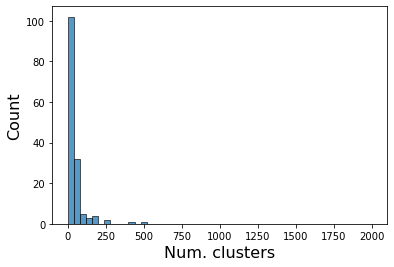

In [210]:
sn.histplot(df['n_clusters'], bins=50, binrange=(0,2000))
plt.ylabel('Count', size=16)
plt.xlabel('Num. clusters', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/zld-cterm_nclusters_hist.png', dpi=300)

In [21]:
np.savetxt('/Users/michaelstadler/Desktop/from.txt', names_target, fmt='%s')

In [22]:
target_ims = load_matches('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images', names_target)
source_ims = load_matches('/Volumes/stadler_5tb/real-nuclei-set3-matched-20220630', names_source)

In [25]:
view_matches(source_ims * 1000, target_ims * 1000, zmax=False)

(74, 34, 100, 100) (74, 34, 100, 100)


interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'magma', 'cividis', 'viridis', …

### Strategizing some

I think just publish this as is. It can be better but it's there now.

Do Rpb1 nc12, 13, 14, benchmarking with nanocages

Do Zld wt, mut, C-term in nc13

Maybe Zld vs. Bicoid?

And then move the fuck on.

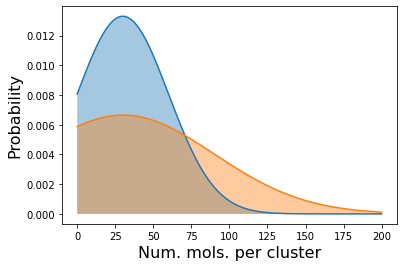

In [8]:
import scipy.stats as stats
x = np.arange(0,200,0.1)
y1 = stats.norm.pdf(x, loc=30, scale=30)
y2 = stats.norm.pdf(x, loc=30, scale=60)
plt.plot(x, y1)
plt.fill_between(x, y1, alpha=0.4)
plt.plot(x, y2)
plt.fill_between(x, y2, alpha=0.4)
plt.xlabel('Num. mols. per cluster', size=16)
plt.ylabel('Probability', size=16)
plt.savefig('/Users/michaelstadler/Documents/presentations/jobtalks/CZI/distros_molspercluster.png', dpi=300)

In [248]:
?stats.norm.pdf

Signature: stats.norm.pdf(x, *args, **kwds)
Docstring:
Probability density function at x of the given RV.

Parameters
----------
x : array_like
    quantiles
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
pdf : ndarray
    Probability density function evaluated at x
File:      ~/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [247]:
type(y1)

tuple

In [12]:
L = ((150e-9) ** 3) * 1000
#L = (250e-9) * ((85e-9) ** 2) * 1000
mols = 1 / 6.02e23
M = mols / L
nM = M * 1e9
nM

919.6565082941522

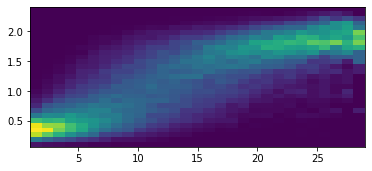

In [208]:
def extract_jitteredparam_dists(embedding_pkl_file):
    """Recover distance in embedding and paramater distance from embedding of 
    jittered simulations -- simulations where all parameters but one are
    fixed.
    
    Args:
        embedding_pkl_file: str
            Path to pickled tuple with embedding and filenames
    
    Returns:
        param_diffs: ndarray
            Absolute values of differences in jittered parameter
        embedding_dists: ndarray
            Euclidean distance in embedding space
    """
    embedding, names = fm.load_pickle(embedding_pkl_file)
    
    # Extract parameters from names (except number of molecules).
    params = []
    for name in names:
        params.append(name.split('_')[2:-1])
    params = np.array(params)
    params = params.astype(float)

    # For each row, find the entries that differ in only one parameters, add distances to
    # arrays.
    param_diffs = []
    embedding_dists = []
    for i in range(embedding.shape[0]): 
        diffs = params - params[i]   
        bool_1diff = np.count_nonzero(diffs, axis=1) == 1
        diffs_1diff = diffs[bool_1diff]
        # Reduce to just column with diffs
        diffs_1diff = np.squeeze(diffs_1diff[:, np.count_nonzero(diffs_1diff, axis=0) > 0])
        param_diffs.extend(diffs_1diff)

        embedding_1diff = embedding[bool_1diff]
        dists = np.sqrt(np.sum((embedding_1diff - embedding[i]) ** 2, axis=1))
        embedding_dists.extend(dists)
    
    return np.array(param_diffs), np.array(embedding_dists)
        


p, e, h = ev.extract_jitteredparam_dists('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__jittered-rpb1-cluster_nmols_mean_zgKFGbPn__20220619-plussims-20220616-realreal.pkl', plot=True, vmax=200)

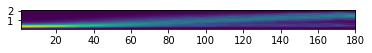

In [207]:
p, e, h = ev.extract_jitteredparam_dists(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__jittered-rpb1-nclusters_TCtBnayZ__20220619-plussims-20220616-realreal.pkl', plot=True, vmax=200)

In [206]:
fm.save_pickle(h,'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/figuredata/the-CNN-works/nclusters.pkl')

3.265310389789196


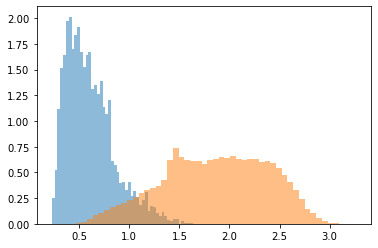

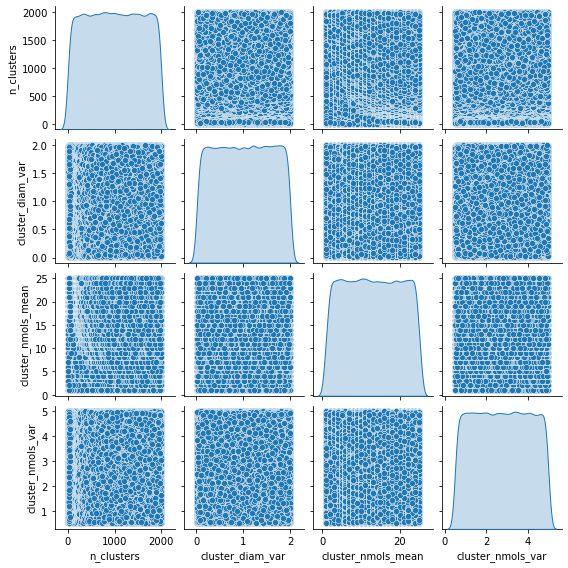

In [21]:
source = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl')
#target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__sims-zld-nc13-25nM-noise2-4ish_100k_EgdrVRpv__20220619-plussims-20220616-realreal.pkl')
target = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl')
names_source, names_target, df2 = match_embeddings(source, target, 'zld-wt', 5000000, protein='tf')

<AxesSubplot:>

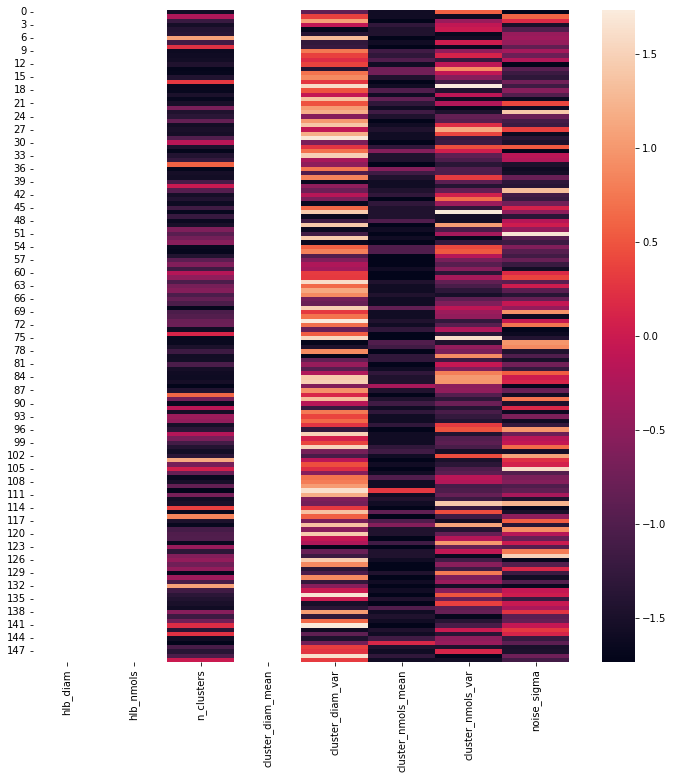

In [19]:
x = (df - df2.mean())/ df2.std()
plt.subplots(figsize=(12,12))
sns.heatmap(x)

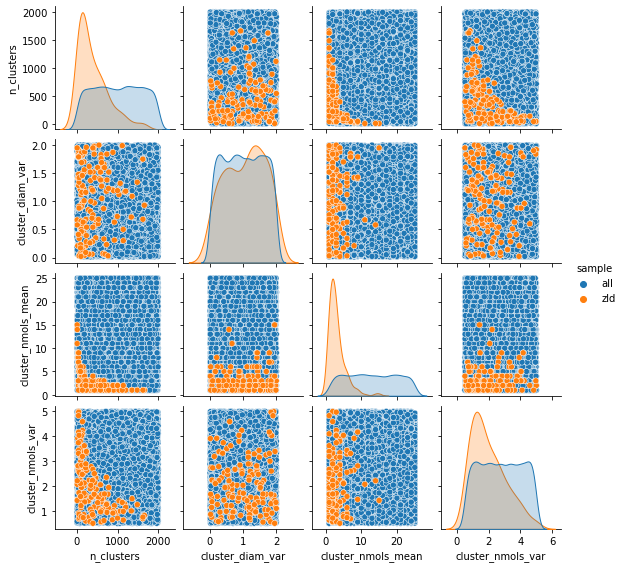

In [40]:
df['sample'] = 'zld'
df2['sample'] = 'all'
df3_ = df2.iloc[np.random.choice(np.arange(df2.shape[0]), size=10_000, replace=False)]
df3  = pd.concat([df3_, df], ignore_index=True)
sn.pairplot(data=df3[['n_clusters','cluster_diam_var','cluster_nmols_mean','cluster_nmols_var', 'sample']], diag_kind='kde', kind='scatter', hue='sample', plot_kws=dict(alpha=1), diag_kws=dict(common_norm=False), height=2)
#sn.pairplot(data=df3_[['n_clusters','cluster_diam_var','cluster_nmols_mean','cluster_nmols_var', 'sample']], diag_kind='kde', kind='scatter', hue='sample', plot_kws=dict(alpha=0.4), height=2)
#sn.pairplot(data=df[['n_clusters','cluster_diam_var','cluster_nmols_mean','cluster_nmols_var', 'sample']], diag_kind='kde', kind='scatter', hue='sample', plot_kws=dict(alpha=0.4), height=2)


In [3]:
e, n = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__jittered-rpb1-nclusters_TCtBnayZ__20220619-plussims-20220616-realreal.pkl')

In [23]:
param_diffs, embedding_dists, h, param_ref, param_target =  ev.extract_jitteredparam_dists('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__jittered-rpb1-nclusters_TCtBnayZ__20220619-plussims-20220616-realreal.pkl')

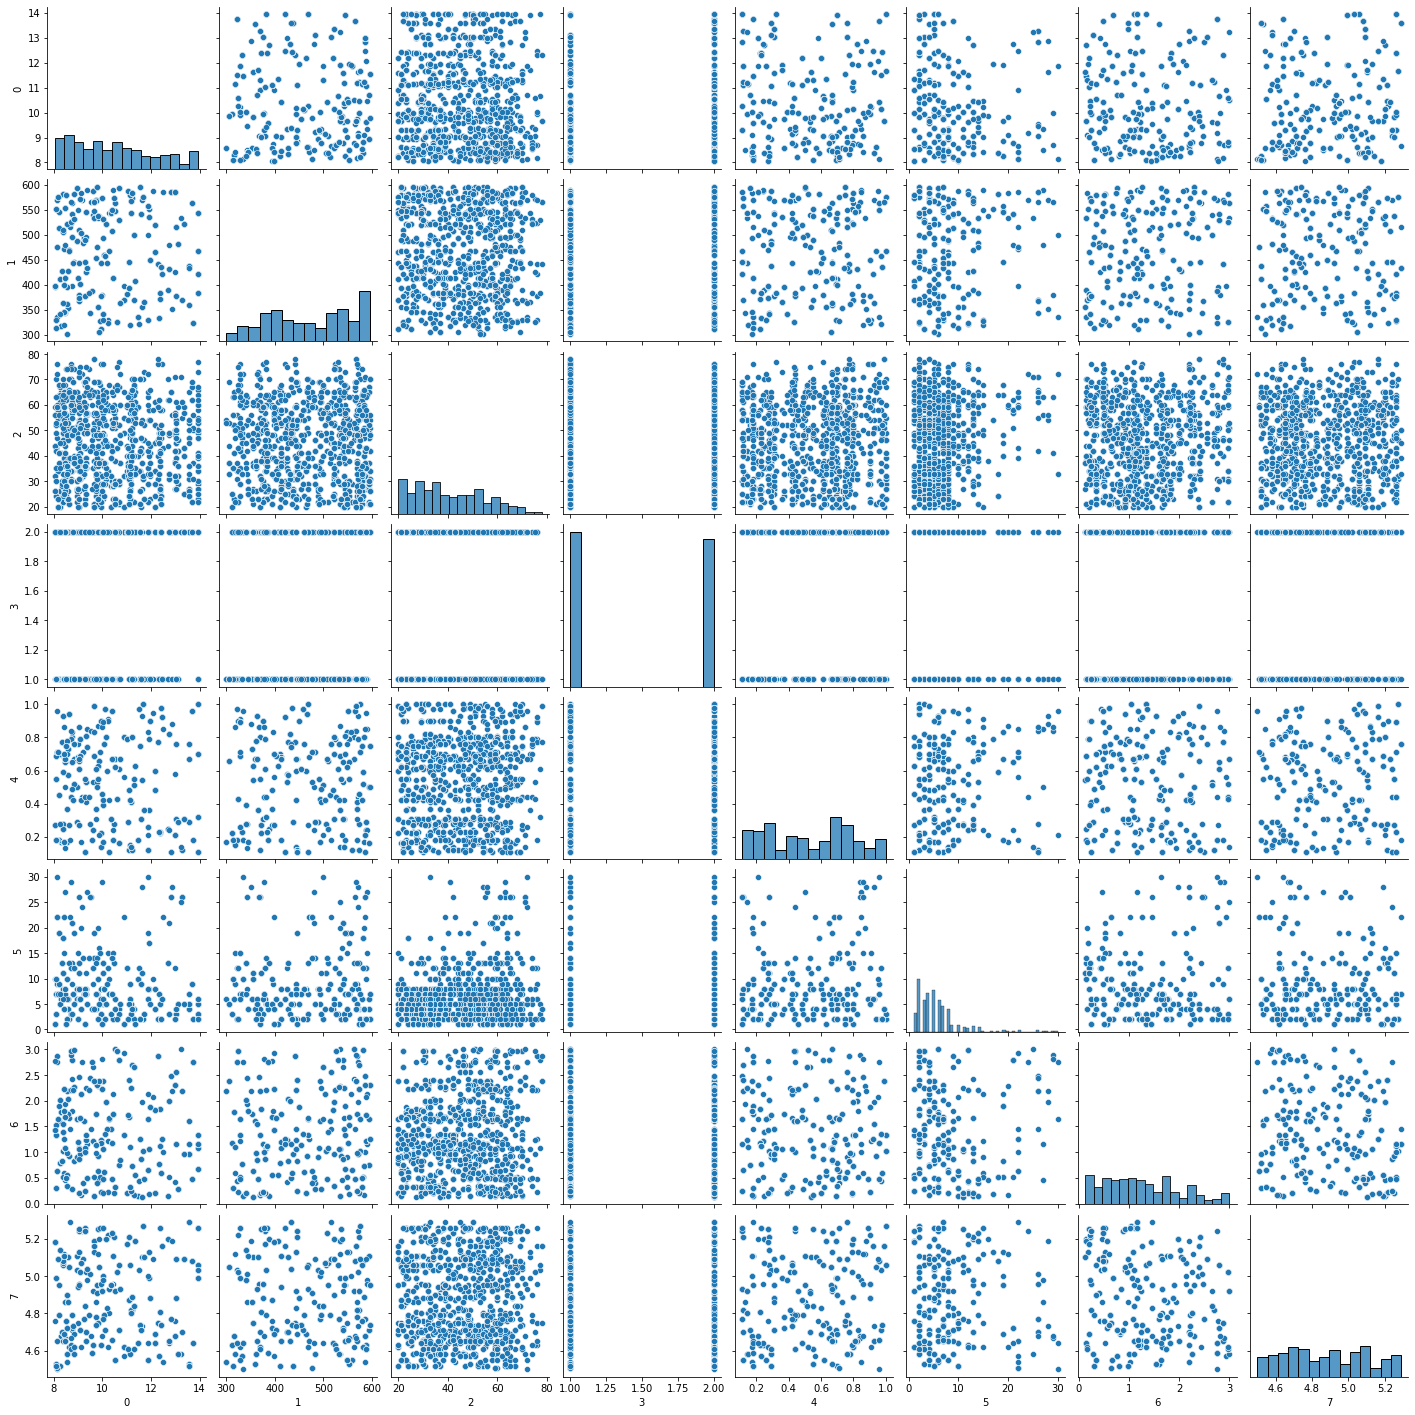

In [26]:

sns.pairplot(pd.DataFrame(param_ref[(param_diffs > 120) & (embedding_dists < 0.75)]))

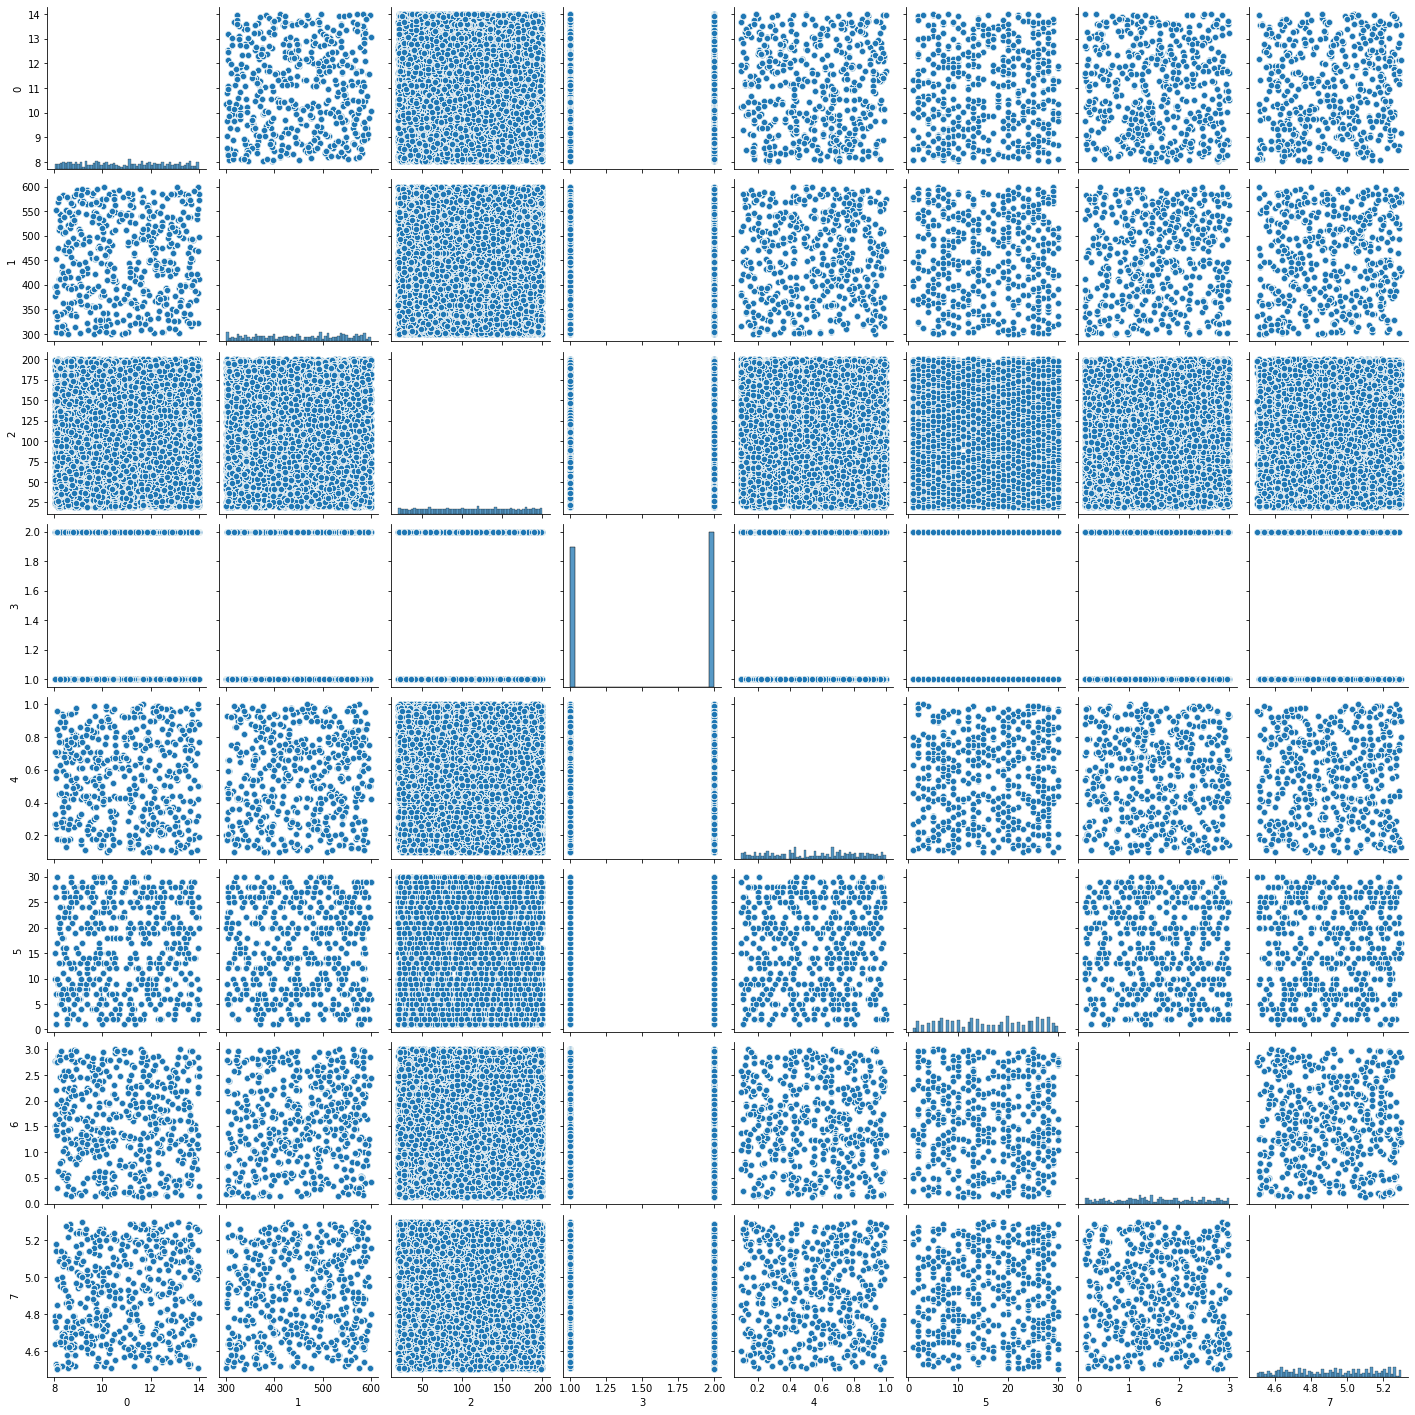

In [27]:
sns.pairplot(pd.DataFrame(param_ref))

In [38]:
import argparse

def parse_args():
    parser = argparse.ArgumentParser(description='.')
    parser.add_argument("--outfolder", type=str,  required=True)
    parser.add_argument("--hlb_diam_rng", type=float, nargs=2, required=True)
    parser.add_argument("--hlb_nmols_rng", type=float, nargs=2, required=True)
    parser.add_argument("--nclusters_rng", type=float, nargs=2, required=True)
    parser.add_argument("--cluster_diam_mean_rng", type=float, nargs=2, required=True)
    parser.add_argument("--cluster_diam_var_rng", type=float, nargs=2, required=True)
    parser.add_argument("--cluster_nmols_mean_rng", type=float, nargs=2, required=True)
    parser.add_argument("--cluster_nmols_var_rng", type=float, nargs=2, required=True)
    parser.add_argument( "--noise_sigma_rng", type=float, nargs=2, required=True)
    parser.add_argument( "--concentration", type=float, required=True)
    parser.add_argument( "--kernel_file", type=str, required=True)
    parser.add_argument( "--mask_file", type=str, required=True)
    parser.add_argument( "--param_tojitter", type=str, required=True)
    parser.add_argument( "--num_batches", type=int, required=True)
    parser.add_argument( "--num_bins", type=int, required=True)
    parser.add_argument("--nprocesses", type=int, required=False, default=20)
    parser.add_argument("--gfp_intensity", type=float, required=False, default=1)
    parser.add_argument("--dims_init", type=int, required=False, nargs=3, default=(85,85,85))
    parser.add_argument("--dims_kernel", type=int, required=False, nargs=3, default=(100,50,50))
    parser.add_argument("--dims_final", type=int, required=False, nargs=3, default=(250,85,85))
    parser.add_argument("--dims_dilation", type=int, required=False, nargs=3, default=(1,7,7))
    parser.add_argument("--mask_nuclei", action='store_true')
       
    args = parser.parse_args()
    return args


args = parse_args()

usage: ipykernel_launcher.py [-h] --outfolder OUTFOLDER --hlb_diam_rng
                             HLB_DIAM_RNG HLB_DIAM_RNG --hlb_nmols_rng
                             HLB_NMOLS_RNG HLB_NMOLS_RNG --nclusters_rng
                             NCLUSTERS_RNG NCLUSTERS_RNG
                             --cluster_diam_mean_rng CLUSTER_DIAM_MEAN_RNG
                             CLUSTER_DIAM_MEAN_RNG --cluster_diam_var_rng
                             CLUSTER_DIAM_VAR_RNG CLUSTER_DIAM_VAR_RNG
                             --cluster_nmols_mean_rng CLUSTER_NMOLS_MEAN_RNG
                             CLUSTER_NMOLS_MEAN_RNG --cluster_nmols_var_rng
                             CLUSTER_NMOLS_VAR_RNG CLUSTER_NMOLS_VAR_RNG
                             --noise_sigma_rng NOISE_SIGMA_RNG NOISE_SIGMA_RNG
                             --concentration CONCENTRATION --kernel_file
                             KERNEL_FILE --mask_file MASK_FILE
                             --param_tojitter PARAM_TOJITTER --num_

SystemExit: 2

In [37]:
for arg in vars(args):
    print(arg)

description
argument_default
prefix_chars
conflict_handler
_registries
_actions
_option_string_actions
_action_groups
_mutually_exclusive_groups
_defaults
_negative_number_matcher
_has_negative_number_optionals
prog
usage
epilog
formatter_class
fromfile_prefix_chars
add_help
allow_abbrev
exit_on_error
_positionals
_optionals
_subparsers


In [39]:
str([1,2,3])

'[1, 2, 3]'